In [13]:
# Initial setup
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

df_full = pd.read_json('yelp_academic_dataset_business.json', lines = True)
tip = pd.read_json('yelp_academic_dataset_tip.json', lines = True)

## 1. Data Preprocessing
In this section, we will transform the Yelp dataset and produce the format required for data mining and modeling through the following steps:

- Filter to U.S. restaurants that were opened in 2016
- Flatten attributes and categories
- Transform categorical variables into dummy variables
- Handling missing values

In [14]:
# Filter to U.S. restaurants that were opened in 2016
# 1) Filter to U.S. businesses
zip_crosswalk = pd.read_csv('zip_crosswalk.csv')
zip_crosswalk = zip_crosswalk.drop_duplicates(subset = ['ZIP', 'STATE'], keep = False)[['ZIP', 'STATE']]
# Transform digit-only postal code to int
digit_only = df_full['postal_code'].map(lambda x: True if all(i.isdigit() for i in x) else False)
df_full = df_full[(digit_only) & (df_full['postal_code'] != '')]
df_full['postal_code_int'] = [int(x) for x in df_full['postal_code']]
# Join crosswalk by zip and state
df_us = pd.merge(df_full, zip_crosswalk[['ZIP', 'STATE']], 
              left_on = ['postal_code_int', 'state'],
              right_on = ['ZIP', 'STATE'])

# 2) Filter to restaurants
df_us = df_us[df_us['categories'].str.contains('Restaurants|Food', na = False)]
df_us.set_index('business_id')

# 3) Filter to restaurants that were opened in 2016
start = '2016-01-01'
end = '2016-12-31'
tip = tip.groupby('business_id')['date'].min().reset_index()
tip = tip[(tip['date'] >= start) & (tip['date'] <= end)]
df = pd.merge(tip, df_us, on = 'business_id', how = 'inner')

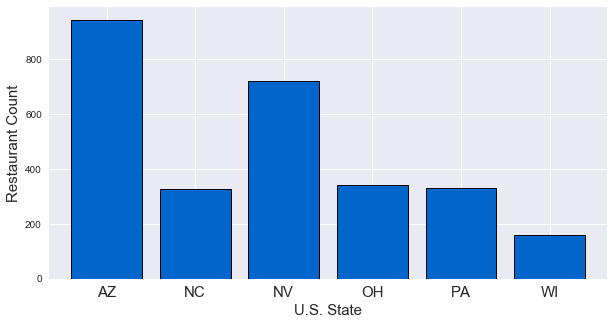

In [33]:
# Check geological distribution
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
df.groupby('state')['business_id'].count().plot(kind = 'bar', color = '#0066cc', width = 0.8, linewidth = 1, edgecolor = 'black')
plt.xlabel('U.S. State', fontsize = 15)
plt.ylabel('Restaurant Count', fontsize = 15)
plt.xticks(fontsize = 15, rotation = 0)
plt.show()

In [15]:
# Drop states with few data points
state_list = ['AZ', 'NC', 'NV', 'OH', 'PA', 'WI']
print('Total data points in df:', len(df))
df = df[np.in1d(df['state'], state_list)].reset_index()
print('Total data points in df after removing a few states:', len(df))

Total data points in df: 2914
Total data points in df after removing a few states: 2827


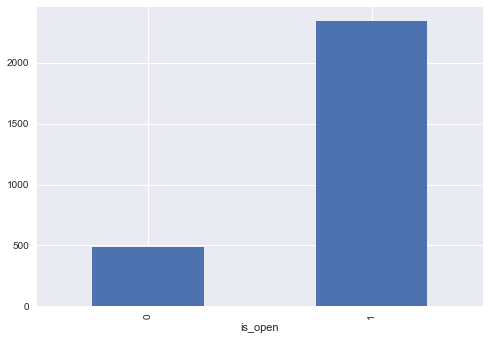

In [165]:
# Check restaurant closure
df.groupby('is_open')['business_id'].count().plot(kind = 'bar')
plt.show()

In [166]:
# Flatten attributes and categories
# 1) Categories
from collections import Counter
# Extract categories from list of lists
cat = ', '.join(df['categories'])
# Count frequency
counter = Counter(cat.split(', '))
# Append categories as dummies
for cat in list(counter.keys()):
    df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
df.drop('categories', inplace = True, axis = 1)

In [167]:
# 2) Attributes
# Unuseful attributes to be dropped
drop_list = ['AcceptsInsurance', 'AgesAllowed', 'Ambience', 'DietaryRestrictions',
             'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'Music', 'ByAppointmentOnly',
             'CoatCheck', 'DogsAllowed' , 'DriveThru', 'GoodForDancing', 'Smoking', 'BusinessParking', 'GoodForMeal']
# Flattening
att = df['attributes'].apply(pd.Series)
meal = att['GoodForMeal'].fillna("{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}")
parking = att['BusinessParking'].fillna("{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}")
parking_list = ['garage', 'street', 'validated', 'lot', 'valet']
meal_list = ['dessert', 'latenight', 'lunch', 'dinner', 'breakfast', 'brunch']

# Define a function to flatten json lists
import ast
def flatten_json(df, col):
    for i in range(len(col)):
        json_dict = ast.literal_eval(col[i])
        for j in json_dict.keys():
            df[j] = np.where(json_dict[j], 1, 0) 
            
flatten_json(df = att, col = parking)
flatten_json(df = att, col = meal)

# Handle missing value in attributes
att['Alcohol'].fillna('none', inplace = True)
att['NoiseLevel'].fillna('average', inplace = True)
att['RestaurantsAttire'].fillna('casual', inplace = True)
att['WiFi'].fillna('no', inplace = True)
att['RestaurantsPriceRange2'].fillna(0, inplace = True)

# Transform attributes into dummy variables
att = att.drop(drop_list, axis = 1).fillna(value = False)
att = pd.get_dummies(att, drop_first = True)

# Append attributes to main dataframe
df = pd.merge(df, att, left_index = True, right_index = True)
df.drop('attributes', axis = 1, inplace = True)

## 2. External Data
In this section, we will integrate the following external data sources to the Yelp dataset:
- Zillow property price data
- Demographic data by zip code

In [168]:
# Zillow
zillow = pd.read_csv('zillow_median_price.csv', encoding='cp1252')
# Extract zipcodes
zipcodes = df['postal_code'].unique()
df['postal_code_int'] = [int(i) for i in df['postal_code']]
house_price = zillow[np.in1d(zillow['RegionName'], 
                             df['postal_code_int'])][['RegionName', '2016-01']]
house_price.columns = ['postal_code_int', 'median_sqft_price']
# Append median house price to main df
df = pd.merge(df, house_price, on = 'postal_code_int', how = 'left')
df['median_sqft_price'] = df['median_sqft_price'].fillna(df['median_sqft_price'].median())

In [169]:
# Add zip-level demographics
from uszipcode import SearchEngine
keys = ['zipcode', 'housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', 
        'occupied_housing_units', 'population', 'population_density', 'annual_individual_earnings', 
        'educational_attainment_for_population_25_and_over', 'employment_status', 'families_vs_singles', 
        'households_with_kids', 'housing_occupancy', 'means_of_transportation_to_work_for_workers_16_and_over', 
        'population_by_age', 'population_by_gender', 'population_by_race', 'travel_time_to_work_in_minutes']
keep_col = ['housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', 
            'occupied_housing_units', 'population', 'population_density', 'postal_code']
lst = []
for zipcode in zipcodes:
    search = SearchEngine(simple_zipcode=False) 
    item = search.by_zipcode(zipcode)
    newDict  = item.to_dict()
    lst.append([newDict.get(key) for key in keys])
keys[0] = 'postal_code'
df_demograph = pd.DataFrame(lst, columns= keys)[keep_col]
df = pd.merge(df, df_demograph, on = 'postal_code', how='inner')

## 3. Feature Engineering
In this section, we will perform feature engineering to extract the following attributes:
- Restaurant density and competition level in the neighborhood
- Whether a given restaurant belong to a local/national chain

In [22]:
# Restaurant density
import geopy.distance
business_id = []
density = []
avg_stars = []
avg_review_count = []
std_stars = []
std_review_count = []

# Create a random sample from all U.S. restaurants (n = 10000) to calculate restaurant density
df_us = df_us[np.in1d(df_us['state'], state_list)]
df_us = df_us.dropna(subset = ['latitude', 'longitude'], axis = 0).reset_index()
sample_us = df_us.drop_duplicates(subset=['latitude', 'longitude', 'stars', 'review_count']).sample(n = 10000).reset_index()

In [23]:
for i in range(len(df)):
    print('Looping over', i, '...')
    coord1 = [df.at[i, 'latitude'], df.at[i, 'longitude']]
    count = 1
    stars = 0
    review_count = 0
    for j in range(len(sample_us)):
        coord2 = [sample_us.at[j, 'latitude'], sample_us.at[j, 'longitude']]
        try:
            distance = geopy.distance.vincenty(coord1, coord2).miles
            if distance < 1:
                count = count + 1
                stars = stars + sample_us.at[j, 'stars']
                review_count = review_count + sample_us.at[j, 'review_count']
        except:
            print('Error!')
    business_id.append(df.at[i, 'business_id'])
    density.append(count)
    avg_stars.append(stars/count)
    avg_review_count.append(review_count/count)

Looping over 0 ...
Looping over 1 ...
Looping over 2 ...
Looping over 3 ...
Looping over 4 ...
Looping over 5 ...
Looping over 6 ...
Looping over 7 ...
Looping over 8 ...
Looping over 9 ...
Looping over 10 ...
Looping over 11 ...
Looping over 12 ...
Looping over 13 ...
Looping over 14 ...
Looping over 15 ...
Looping over 16 ...
Looping over 17 ...
Looping over 18 ...
Looping over 19 ...
Looping over 20 ...
Looping over 21 ...
Looping over 22 ...
Looping over 23 ...
Looping over 24 ...
Looping over 25 ...
Looping over 26 ...
Looping over 27 ...
Looping over 28 ...
Looping over 29 ...
Looping over 30 ...
Looping over 31 ...
Looping over 32 ...
Looping over 33 ...
Looping over 34 ...
Looping over 35 ...
Looping over 36 ...
Looping over 37 ...
Looping over 38 ...
Looping over 39 ...
Looping over 40 ...
Looping over 41 ...
Looping over 42 ...
Looping over 43 ...
Looping over 44 ...
Looping over 45 ...
Looping over 46 ...
Looping over 47 ...
Looping over 48 ...
Looping over 49 ...
Looping ov

In [170]:
biz_density = pd.DataFrame({'business_id': business_id,
                            'density' : density,
                            'avg_stars' : avg_stars,
                            'avg_review_count' : avg_review_count})
df = pd.merge(df, biz_density, on = 'business_id')

In [171]:
# Identify whether a given restaurant is a local or national chain
local_chain = df.groupby(['state', 'name'])['business_id'].count().reset_index()
local_chain.columns = ['state', 'name', 'count']
local_chain['is_local_chain'] = np.where(local_chain['count'] > 1, 1, 0)

national_chain = local_chain.groupby('name')['state'].count().reset_index()
national_chain.columns = ['name', 'count']
national_chain['is_national_chain'] = np.where(national_chain['count'] > 2, 1, 0)

df = pd.merge(df, local_chain[['name', 'state', 'is_local_chain']], on = ['state','name'], how = 'left')
df = pd.merge(df, national_chain[['name', 'is_national_chain']], on = ['name'], how = 'left')

In [172]:
# Data Cleaning
# pd.set_option("display.max_columns",500)
# Drop non-features
drop_col = ['index', 'business_id', 'date', 'address', 'hours', 
            'latitude','longitude','name','review_count','stars',
            'neighborhood', 'postal_code', 'postal_code_int', 'ZIP', 'STATE']
# Drop zipcide with missing value
df_clean = df[(df['postal_code'] != '89158') & (df['postal_code'] != '85378')].drop(drop_col, axis = 1)

In [173]:
# Convert categorical variables to dummies
dummy_col = ['city', 'state']
df_clean = pd.get_dummies(data = df_clean, columns = dummy_col).dropna(how = 'any')

### 4. Modeling

In [3]:
# Resampling
df_clean.groupby('is_open')['is_open'].count()

is_open
0     485
1    2324
Name: is_open, dtype: int64

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler

X = df_clean.drop('is_open', axis = 1)
y = np.where(df_clean['is_open'] == 1, 0, 1)

# Scale Transform X
cols = X.columns
trans = RobustScaler().fit(X)
X = pd.DataFrame(trans.transform(X))
X.columns = cols

# Perform stratified 4-fold
k = 4
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 123)

#### 4.1 Logistic regression (baseline)

In [70]:
# Baseline: logitstic regression with regularization + grid search
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn import metrics

auc = []
pr_auc = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class
    X_close = X_train.iloc[y_train == 1, :]
    X_open = X_train.iloc[y_train == 0, :]
    y_close = y_train[y_train == 1]
    y_open = y_train[y_train == 0]
    X_close, y_close = resample(X_close, y_close, n_samples = len(X_open), random_state = 123)
    X_train = pd.concat([X_close, X_open])
    y_train = np.concatenate((y_close, y_open))
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
    auc.append(metrics.auc(fpr, tpr))
    pr_auc.append(metrics.average_precision_score(y_test, y_pred[:, 1]))

print('The average PR-AUC is', np.mean(pr_auc))
print('The standard deviation is', np.std(pr_auc))
print('The average AUC is', np.mean(auc))
print('The standard deviation is', np.std(auc))

The average PR-AUC is 0.262434677394
The standard deviation is 0.0185689956635
The average AUC is 0.627825001207
The standard deviation is 0.00789074777414


In [71]:
# Logistic regression with SMOTE
from imblearn.over_sampling import SMOTE
auc = []
pr_auc = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data using SMOTE
    X_train, y_train = SMOTE(random_state = 123).fit_resample(X_train, y_train)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
    auc.append(metrics.auc(fpr, tpr))
    pr_auc.append(metrics.average_precision_score(y_test, y_pred[:, 1]))

print('The average PR-AUC is', np.mean(pr_auc))
print('The standard deviation is', np.std(pr_auc))
print('The average AUC is', np.mean(auc))
print('The standard deviation is', np.std(auc))

The average PR-AUC is 0.27236777727
The standard deviation is 0.0220993384793
The average AUC is 0.635614632257
The standard deviation is 0.0107345016539


In [72]:
#### Logistic regression with regularization grid search
auc = []
pr_auc = []
penalty = []
reg = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data
    X_close = X_train.iloc[y_train == 1, :]
    X_open = X_train.iloc[y_train == 0, :]
    y_close = y_train[y_train == 1]
    y_open = y_train[y_train == 0]
    X_close, y_close = resample(X_close, y_close, n_samples = len(X_open))
    X_train = pd.concat([X_close, X_open])
    y_train = np.concatenate((y_close, y_open))
    
    for p in ['l1', 'l2']:
        for c in [10**i for i in range(-3, 3)]:
            lr = LogisticRegression(penalty = p, C = c)
            lr.fit(X_train, y_train)
            y_pred = lr.predict_proba(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
            auc.append(metrics.auc(fpr, tpr))
            pr_auc.append(metrics.average_precision_score(y_test, y_pred[:, 1]))
            penalty.append(p)
            reg.append(c)

auc_df_lr = pd.DataFrame({'penalty' : penalty,
                       'C': reg,
                       'auc' : auc})
auc_df_lr.groupby(['penalty', 'C']).agg({'auc' : ['mean', 'std']}).reset_index()

penalty        C       auc          
                         mean       std
0       l1    0.001  0.500000  0.000000
1       l1    0.010  0.573895  0.051415
2       l1    0.100  0.661154  0.011737
3       l1    1.000  0.629820  0.015506
4       l1   10.000  0.612605  0.022391
5       l1  100.000  0.600601  0.025733
6       l2    0.001  0.612337  0.036296
7       l2    0.010  0.646645  0.015036
8       l2    0.100  0.643712  0.012977
9       l2    1.000  0.627812  0.016423
10      l2   10.000  0.616620  0.021392
11      l2  100.000  0.605230  0.024108

In [73]:
#### Logistic regression with regularization grid search + SMOTE
auc = []
penalty = []
reg = []
pr_auc = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data using SMOTE
    X_train, y_train = SMOTE(random_state = 123).fit_resample(X_train, y_train)
    
    for p in ['l1', 'l2']:
        for c in [10**i for i in range(-3, 3)]:
            lr = LogisticRegression(penalty = p, C = c)
            lr.fit(X_train, y_train)
            y_pred = lr.predict_proba(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
            auc.append(metrics.auc(fpr, tpr))
            pr_auc.append(metrics.average_precision_score(y_test, y_pred[:, 1]))
            penalty.append(p)
            reg.append(c)

auc_df_lr = pd.DataFrame({'penalty' : penalty,
                       'C': reg,
                       'auc' : auc})
auc_df_lr.groupby(['penalty', 'C']).agg({'auc' : ['mean', 'std']}).reset_index()

penalty        C       auc          
                         mean       std
0       l1    0.001  0.500000  0.000000
1       l1    0.010  0.602358  0.031382
2       l1    0.100  0.664653  0.006511
3       l1    1.000  0.634546  0.009625
4       l1   10.000  0.619294  0.015061
5       l1  100.000  0.608085  0.018186
6       l2    0.001  0.618091  0.033320
7       l2    0.010  0.651773  0.013653
8       l2    0.100  0.651735  0.008647
9       l2    1.000  0.635615  0.012395
10      l2   10.000  0.622386  0.018325
11      l2  100.000  0.611362  0.018879

#### 4.2 Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
auc = []
n_tree = []
max_features = []
criterion = []
max_depth = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data
    X_close = X_train.iloc[y_train == 1, :]
    X_open = X_train.iloc[y_train == 0, :]
    y_close = y_train[y_train == 1]
    y_open = y_train[y_train == 0]
    X_close, y_close = resample(X_close, y_close, n_samples = len(X_open), random_state = 123)
    X_train = pd.concat([X_close, X_open])
    y_train = np.concatenate((y_close, y_open))
    
    for n in [5*i for i in range(10, 30)]:
        for m in ['sqrt', 'log2']:
            for c in ['gini', 'entropy']:
                for d in [np.linspace(10, 100, num = 10)]:
                    rf = RandomForestClassifier(n_estimators = 100)
                    rf.fit(X_train, y_train)
                    y_pred = rf.predict_proba(X_test)
                    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
                    auc.append(metrics.auc(fpr, tpr))
                    n_tree.append(n)
                    max_features.append(m)
                    criterion.append(c)
                    max_depth.append(d)

auc_df_rf = pd.DataFrame({'n_tree' : n_tree,
                       'max_features': max_features,
                       'criterion' : criterion,
                       'max_depth' : max_depth,
                       'auc' : auc})
auc_df_rf.groupby(['n_tree', 'max_features', 'criterion', 'max_depth']).agg({'auc' : ['mean', 'std']}).reset_index()

n_tree max_features criterion       auc          
                                      mean       std
0      15         log2   entropy  0.639230  0.013349
1      15         log2      gini  0.643233  0.030068
2      15         sqrt   entropy  0.642944  0.017704
3      15         sqrt      gini  0.637416  0.020369
4      20         log2   entropy  0.645487  0.010863
5      20         log2      gini  0.645561  0.008597
6      20         sqrt   entropy  0.649619  0.024685
7      20         sqrt      gini  0.642111  0.011852
8      25         log2   entropy  0.647719  0.017332
9      25         log2      gini  0.660926  0.016451
10     25         sqrt   entropy  0.638092  0.025598
11     25         sqrt      gini  0.637346  0.018711
12     30         log2   entropy  0.636113  0.017928
13     30         log2      gini  0.641337  0.022632
14     30         sqrt   entropy  0.640218  0.020387
15     30         sqrt      gini  0.651856  0.020294
16     35         log2   entropy  0.648133  0.013134
17     35         log2      gini  0.644413  0.023872
18     35         sqrt   entropy  0.645445  0.032263
19     35         sqrt      gini  0.648545  0.019478
20     40         log2   entropy  0.652776  0.015992
21     40         log2      gini  0.635721  0.020646
22     40         sqrt   entropy  0.648156  0.010903
23     40         sqrt      gini  0.645817  0.025205
24     45         log2   entropy  0.643890  0.031433
25     45         log2      gini  0.639014  0.015320
26     45         sqrt   entropy  0.653880  0.014481
27     45         sqrt      gini  0.646781  0.018345

In [90]:
auc = []
n_tree = []
max_features = []
criterion = []
max_depth = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data using SMOTE
    X_train, y_train = SMOTE(random_state = 123).fit_resample(X_train, y_train)
    
    for n in [50, 100, 150]:
        for m in ['sqrt', 'log2']:
            for c in ['gini', 'entropy']:
                for d in [int(d) for d in np.linspace(10, 100, num = 10)]:
                    rf = RandomForestClassifier(n_estimators = 100)
                    rf.fit(X_train, y_train)
                    y_pred = rf.predict_proba(X_test)
                    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
                    auc.append(metrics.auc(fpr, tpr))
                    n_tree.append(n)
                    max_features.append(m)
                    criterion.append(c)
                    max_depth.append(d)

In [92]:
pd.set_option("display.max_rows",500)
auc_df_rf = pd.DataFrame({'n_tree' : n_tree,
                       'max_features': max_features,
                       'criterion' : criterion,
                       'max_depth' : max_depth,
                       'auc' : auc})
auc_df_rf.groupby(['n_tree', 'max_features', 'criterion', 'max_depth']).agg({'auc' : ['mean', 'std']}).reset_index()

n_tree max_features criterion max_depth       auc          
                                                 mean       std
0       50         log2   entropy        10  0.656977  0.014277
1       50         log2   entropy        20  0.650458  0.008813
2       50         log2   entropy        30  0.652352  0.003316
3       50         log2   entropy        40  0.651333  0.012584
4       50         log2   entropy        50  0.652417  0.023381
5       50         log2   entropy        60  0.650435  0.011695
6       50         log2   entropy        70  0.646815  0.009836
7       50         log2   entropy        80  0.654218  0.011652
8       50         log2   entropy        90  0.652642  0.007735
9       50         log2   entropy       100  0.658232  0.013832
10      50         log2      gini        10  0.649173  0.020865
11      50         log2      gini        20  0.654275  0.008336
12      50         log2      gini        30  0.654422  0.017046
13      50         log2      gini        40  0.656375  0.013897
14      50         log2      gini        50  0.652416  0.008246
15      50         log2      gini        60  0.646513  0.024489
16      50         log2      gini        70  0.643006  0.004558
17      50         log2      gini        80  0.653059  0.005161
18      50         log2      gini        90  0.659402  0.002470
19      50         log2      gini       100  0.661076  0.014386
20      50         sqrt   entropy        10  0.658149  0.017976
21      50         sqrt   entropy        20  0.652372  0.010462
22      50         sqrt   entropy        30  0.642076  0.008569
23      50         sqrt   entropy        40  0.653610  0.014604
24      50         sqrt   entropy        50  0.658758  0.018523
25      50         sqrt   entropy        60  0.649510  0.007466
26      50         sqrt   entropy        70  0.656267  0.008445
27      50         sqrt   entropy        80  0.657371  0.016206
28      50         sqrt   entropy        90  0.658163  0.013789
29      50         sqrt   entropy       100  0.640367  0.015141
30      50         sqrt      gini        10  0.650492  0.014831
31      50         sqrt      gini        20  0.657155  0.003803
32      50         sqrt      gini        30  0.660224  0.014675
33      50         sqrt      gini        40  0.649945  0.005840
34      50         sqrt      gini        50  0.648547  0.013883
35      50         sqrt      gini        60  0.648881  0.013571
36      50         sqrt      gini        70  0.649235  0.007358
37      50         sqrt      gini        80  0.654404  0.014927
38      50         sqrt      gini        90  0.649635  0.020883
39      50         sqrt      gini       100  0.660723  0.013476
40     100         log2   entropy        10  0.651287  0.023402
41     100         log2   entropy        20  0.659462  0.009240
42     100         log2   entropy        30  0.660999  0.015863
43     100         log2   entropy        40  0.644097  0.016837
44     100         log2   entropy        50  0.653858  0.015656
45     100         log2   entropy        60  0.646811  0.015014
46     100         log2   entropy        70  0.647154  0.010872
47     100         log2   entropy        80  0.648500  0.017180
48     100         log2   entropy        90  0.653999  0.012134
49     100         log2   entropy       100  0.659926  0.011617
50     100         log2      gini        10  0.652703  0.007983
51     100         log2      gini        20  0.650772  0.007976
52     100         log2      gini        30  0.644007  0.007495
53     100         log2      gini        40  0.645337  0.014853
54     100         log2      gini        50  0.643146  0.011659
55     100         log2      gini        60  0.649167  0.010187
56     100         log2      gini        70  0.659097  0.016343
57     100         log2      gini        80  0.641004  0.014283
58     100         log2      gini        90  0.646641  0.008723
59     100         log2      gini       100  0.660836  0.011213
60     100         sqrt   entropy   

#### 4.3 Gradient Boosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

auc = []
n_tree = []
learning_rate = []
max_depth = []
gamma = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # Upsample minority class in training data
    X_close = X_train.iloc[y_train == 1, :]
    X_open = X_train.iloc[y_train == 0, :]
    y_close = y_train[y_train == 1]
    y_open = y_train[y_train == 0]
    X_close, y_close = resample(X_close, y_close, n_samples = len(X_open), random_state = 123)
    X_train = pd.concat([X_close, X_open])
    y_train = np.concatenate((y_close, y_open))
    
    for n in [50, 100, 150, 200]:
        for i in [0.001, 0.01, 0.1, 0.2]:
            xgb = XGBClassifier(n_estimators = n, learning_rate = i)
            xgb.fit(X_train, y_train)
            y_pred = xgb.predict_proba(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1])
            auc.append(metrics.auc(fpr, tpr))
            n_tree.append(n)
            learning_rate.append(i)    

In [11]:
pd.set_option("display.max_rows",500)
auc_df_xgb = pd.DataFrame({'n_tree' : n_tree,
                           'learning_rate' : learning_rate,
                           'auc' : auc})
auc_df_xgb.groupby(['n_tree', 'learning_rate']).agg({'auc' : ['mean', 'std']}).reset_index()

n_tree learning_rate       auc          
                             mean       std
0      50         0.001  0.582094  0.019860
1      50         0.010  0.624550  0.009055
2      50         0.100  0.636572  0.017670
3      50         0.200  0.638593  0.020663
4     100         0.001  0.605124  0.014770
5     100         0.010  0.632707  0.010251
6     100         0.100  0.637982  0.020950
7     100         0.200  0.632894  0.016666
8     150         0.001  0.608148  0.014879
9     150         0.010  0.638669  0.012034
10    150         0.100  0.638751  0.023351
11    150         0.200  0.634206  0.020181
12    200         0.001  0.609286  0.011629
13    200         0.010  0.642204  0.014391
14    200         0.100  0.635622  0.022156
15    200         0.200  0.635001  0.012725